<a href="https://colab.research.google.com/github/aaubs/ds-master/blob/main/notebooks/M1_Clustering_v4_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering Methods: Hierarchical vs. K-means Clustering Techniques

<img src="https://raw.githubusercontent.com/aaubs/ds-master/main/data/Images/nba_Clustering_yale.png" width="800" height="800">


[Clustering NBA Players](https://sports.sites.yale.edu/clustering-nba-players)


- **Partitioning (Centroid-based) Methods:** This method divides data into a set number of groups so that items in each group are as similar as possible. K-means is a popular way to do this.

- **Hierarchical Methods:** This method sorts data into groups in a tree-like shape, using how close or far the items are from each other.

- **Density-based Methods:** This method puts data points into groups based on how many are packed closely together. DBSCAN and OPTICS are common ways to do density-based clustering.

![](https://raw.githubusercontent.com/aaubs/ds-master/main/data/Images/clustering_methods.png)






In [1]:
import pandas as pd

nba = pd.read_csv('https://raw.githubusercontent.com/aaubs/ds-master/main/data/NBA_Data.csv')

# Agglomerative Approach: A Bottom-Up Perspective on Hierarchical Clustering

This method sorts data into groups in a tree-like shape. It can work either bottom-up, starting with individual items and combining them, or top-down, starting with one big group and splitting it.





1. Bottom-Up Clustering: Starts with individual items and combines them into bigger groups step-by-step.

2. Top-Down Clustering: Begins with one large group and splits it into smaller groups step-by-step.

![](https://raw.githubusercontent.com/aaubs/ds-master/main/data/Images/agglomerative_clustering.jpeg)

 Bottom-up approach cotains three steps in hierarchical clustering as follows:


> - Step 1: Calcaulte the similarity matrix between all pairs of players
> - Step 2: Find and merge the nearest pairs of players
> - Step 3: Keep doing this until all the players end up in one big group

You start with each player as their own group and then keep combining the most similar players until everyone is in one big group.

In [2]:
import random

# Randomly select 7 players from the dataset
selected_players = nba.sample(7, random_state=42)

# Only keep the 'PLAYER', 'AGE', and 'W' columns for the selected players
selected_players = selected_players[['PLAYER', 'PTS', 'REB']].reset_index(drop=True)

# Extract the first names of the players
selected_players['First Name'] = selected_players['PLAYER'].apply(lambda x: x.split()[0])


selected_players

,PLAYER,PTS,REB,First Name
0,Kris Dunn,11.3,4.1,Kris
1,Dusty Hannahs,4.0,0.5,Dusty
2,Kawhi Leonard,26.6,7.3,Kawhi
3,John Henson,5.6,5.1,John
4,D.J. Wilson,5.8,4.6,D.J.
5,Dwyane Wade,15.0,4.0,Dwyane
6,Isaiah Thomas,8.1,1.1,Isaiah


![](https://raw.githubusercontent.com/aaubs/ds-master/main/data/Images/step0.png)

####Step 1. Calcaulte the similarity matrix between all pairs of players

In [3]:
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics import pairwise_distances


# distance_matrix = cosine_distances(selected_players[['PTS', 'REB']])
# Compute the pairwise cosine distance between each pair of players
distance_matrix = pairwise_distances(selected_players[['PTS', 'REB']], metric='euclidean')


# Create a DataFrame for better visualization
distance_df = pd.DataFrame(distance_matrix, index=selected_players['First Name'], columns=selected_players['First Name'])
distance_df = distance_df.round(2)
distance_df

First Name,Kris,Dusty,Kawhi,John,D.J.,Dwyane,Isaiah
First Name,,,,,,,
Kris,0.00,8.14,15.63,5.79,5.52,3.70,4.39
Dusty,8.14,0.00,23.60,4.87,4.48,11.54,4.14
Kawhi,15.63,23.60,0.00,21.11,20.97,12.06,19.51
John,5.79,4.87,21.11,0.00,0.54,9.46,4.72
D.J.,5.52,4.48,20.97,0.54,0.00,9.22,4.19
Dwyane,3.70,11.54,12.06,9.46,9.22,0.00,7.48
Isaiah,4.39,4.14,19.51,4.72,4.19,7.48,0.00


####Step 2. Find and merge the nearest pairs of players

In [4]:
import numpy as np

# Replace diagonal with np.nan
np.fill_diagonal(distance_df.values, np.nan)


# Identify the corresponding row and column (players)
player1, player2 = distance_df.stack().idxmin()
player1, player2

('John', 'D.J.')

In [5]:
# Merge these players based on average
merged_player_stats = selected_players[selected_players['First Name'].isin([player1, player2])][['PTS', 'REB']].mean()
merged_player_name = f"{player1}_{player2}"

# Update the DataFrame to include the new merged player
new_selected_players = selected_players[~selected_players['First Name'].isin([player1, player2])]
new_selected_players = new_selected_players.append({'PLAYER': merged_player_name, 'First Name': merged_player_name, 'PTS': merged_player_stats['PTS'], 'REB': merged_player_stats['REB']}, ignore_index=True)
new_selected_players

<ipython-input-5-2f0f1d156c91>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_selected_players = new_selected_players.append({'PLAYER': merged_player_name, 'First Name': merged_player_name, 'PTS': merged_player_stats['PTS'], 'REB': merged_player_stats['REB']}, ignore_index=True)


,PLAYER,PTS,REB,First Name
0,Kris Dunn,11.3,4.10,Kris
1,Dusty Hannahs,4.0,0.50,Dusty
2,Kawhi Leonard,26.6,7.30,Kawhi
3,Dwyane Wade,15.0,4.00,Dwyane
4,Isaiah Thomas,8.1,1.10,Isaiah
5,John_D.J.,5.7,4.85,John_D.J.


![](https://raw.githubusercontent.com/aaubs/ds-master/main/data/Images/step1.png)

###Step 3. Keep doing this until all the players end up in one big group



In [6]:
# Recompute the distance matrix
new_distance_matrix = pairwise_distances(new_selected_players[['PTS', 'REB']], metric='euclidean')
new_distance_df = pd.DataFrame(new_distance_matrix, index=new_selected_players['First Name'], columns=new_selected_players['First Name'])
new_distance_df = new_distance_df.round(2)

new_distance_df

First Name,Kris,Dusty,Kawhi,Dwyane,Isaiah,John_D.J.
First Name,,,,,,
Kris,0.00,8.14,15.63,3.70,4.39,5.65
Dusty,8.14,0.00,23.60,11.54,4.14,4.67
Kawhi,15.63,23.60,0.00,12.06,19.51,21.04
Dwyane,3.70,11.54,12.06,0.00,7.48,9.34
Isaiah,4.39,4.14,19.51,7.48,0.00,4.45
John_D.J.,5.65,4.67,21.04,9.34,4.45,0.00


In [7]:
import numpy as np

# Replace diagonal with np.nan
np.fill_diagonal(new_distance_df.values, np.nan)


# Identify the corresponding row and column (players)
player1, player2 = new_distance_df.stack().idxmin()
player1, player2

('Kris', 'Dwyane')

In [8]:
# Merge these players based on average
merged_player_stats = new_selected_players[new_selected_players['First Name'].isin([player1, player2])][['PTS', 'REB']].mean()
merged_player_name = f"{player1}_{player2}"

# Update the DataFrame to include the new merged player
new_selected_players_2 = new_selected_players[~new_selected_players['First Name'].isin([player1, player2])]
new_selected_players_2 = new_selected_players_2.append({'PLAYER': merged_player_name, 'First Name': merged_player_name, 'PTS': merged_player_stats['PTS'], 'REB': merged_player_stats['REB']}, ignore_index=True)
new_selected_players_2

<ipython-input-8-a3838a61fb7e>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_selected_players_2 = new_selected_players_2.append({'PLAYER': merged_player_name, 'First Name': merged_player_name, 'PTS': merged_player_stats['PTS'], 'REB': merged_player_stats['REB']}, ignore_index=True)


,PLAYER,PTS,REB,First Name
0,Dusty Hannahs,4.00,0.50,Dusty
1,Kawhi Leonard,26.60,7.30,Kawhi
2,Isaiah Thomas,8.10,1.10,Isaiah
3,John_D.J.,5.70,4.85,John_D.J.
4,Kris_Dwyane,13.15,4.05,Kris_Dwyane


![](https://raw.githubusercontent.com/aaubs/ds-master/main/data/Images/step2.png)

##**Exercise 1: Repeat this process until all the players end up in one big group?**

In [39]:
# Recompute the distance matrix
new_distance_matrix_2 = pairwise_distances(new_selected_players_2[['PTS', 'REB']], metric='euclidean')
new_distance_df_2 = pd.DataFrame(new_distance_matrix_2, index=new_selected_players_2['First Name'], columns=new_selected_players_2['First Name'])
new_distance_df_2 = new_distance_df_2.round(2)

new_distance_df_2

First Name,Dusty,Kawhi,Isaiah,John_D.J.,Kris_Dwyane
First Name,,,,,
Dusty,0.00,23.60,4.14,4.67,9.81
Kawhi,23.60,0.00,19.51,21.04,13.84
Isaiah,4.14,19.51,0.00,4.45,5.85
John_D.J.,4.67,21.04,4.45,0.00,7.49
Kris_Dwyane,9.81,13.84,5.85,7.49,0.00


In [40]:
import numpy as np

# Replace diagonal with np.nan
np.fill_diagonal(new_distance_df_2.values, np.nan)


# Identify the corresponding row and column (players)
player1, player2 = new_distance_df_2.stack().idxmin()
player1, player2

('Dusty', 'Isaiah')

In [41]:
# Merge these players based on average
merged_player_stats = new_selected_players_2[new_selected_players_2['First Name'].isin([player1, player2])][['PTS', 'REB']].mean()
merged_player_name = f"{player1}_{player2}"

# Update the DataFrame to include the new merged player
new_selected_players_3 = new_selected_players_2[~new_selected_players_2['First Name'].isin([player1, player2])]
new_selected_players_3 = new_selected_players_3.append({'PLAYER': merged_player_name, 'First Name': merged_player_name, 'PTS': merged_player_stats['PTS'], 'REB': merged_player_stats['REB']}, ignore_index=True)
new_selected_players_3

<ipython-input-41-b7a039280c38>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_selected_players_3 = new_selected_players_3.append({'PLAYER': merged_player_name, 'First Name': merged_player_name, 'PTS': merged_player_stats['PTS'], 'REB': merged_player_stats['REB']}, ignore_index=True)


,PLAYER,PTS,REB,First Name
0,Kawhi Leonard,26.60,7.30,Kawhi
1,John_D.J.,5.70,4.85,John_D.J.
2,Kris_Dwyane,13.15,4.05,Kris_Dwyane
3,Dusty_Isaiah,6.05,0.80,Dusty_Isaiah


![](https://raw.githubusercontent.com/aaubs/ds-master/main/data/Images/step3.png)

In [42]:
# Recompute the distance matrix
new_distance_matrix_3 = pairwise_distances(new_selected_players_3[['PTS', 'REB']], metric='euclidean')
new_distance_df_3 = pd.DataFrame(new_distance_matrix_3, index=new_selected_players_3['First Name'], columns=new_selected_players_3['First Name'])
new_distance_df_3 = new_distance_df_3.round(2)

new_distance_df_3

First Name,Kawhi,John_D.J.,Kris_Dwyane,Dusty_Isaiah
First Name,,,,
Kawhi,0.00,21.04,13.84,21.55
John_D.J.,21.04,0.00,7.49,4.07
Kris_Dwyane,13.84,7.49,0.00,7.81
Dusty_Isaiah,21.55,4.07,7.81,0.00


In [43]:
import numpy as np

# Replace diagonal with np.nan
np.fill_diagonal(new_distance_df_3.values, np.nan)


# Identify the corresponding row and column (players)
player1, player2 = new_distance_df_3.stack().idxmin()
player1, player2

('John_D.J.', 'Dusty_Isaiah')

In [44]:
# Merge these players based on average
merged_player_stats = new_selected_players_3[new_selected_players_3['First Name'].isin([player1, player2])][['PTS', 'REB']].mean()
merged_player_name = f"{player1}_{player2}"

# Update the DataFrame to include the new merged player
new_selected_players_4 = new_selected_players_3[~new_selected_players_3['First Name'].isin([player1, player2])]
new_selected_players_4 = new_selected_players_4.append({'PLAYER': merged_player_name, 'First Name': merged_player_name, 'PTS': merged_player_stats['PTS'], 'REB': merged_player_stats['REB']}, ignore_index=True)
new_selected_players_4

<ipython-input-44-790c4940be3f>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_selected_players_4 = new_selected_players_4.append({'PLAYER': merged_player_name, 'First Name': merged_player_name, 'PTS': merged_player_stats['PTS'], 'REB': merged_player_stats['REB']}, ignore_index=True)


,PLAYER,PTS,REB,First Name
0,Kawhi Leonard,26.600,7.300,Kawhi
1,Kris_Dwyane,13.150,4.050,Kris_Dwyane
2,John_D.J._Dusty_Isaiah,5.875,2.825,John_D.J._Dusty_Isaiah


![](https://raw.githubusercontent.com/aaubs/ds-master/main/data/Images/step4.png)

In [45]:
# Recompute the distance matrix
new_distance_matrix_4 = pairwise_distances(new_selected_players_4[['PTS', 'REB']], metric='euclidean')
new_distance_df_4 = pd.DataFrame(new_distance_matrix_4, index=new_selected_players_4['First Name'], columns=new_selected_players_4['First Name'])
new_distance_df_ = new_distance_df_4.round(2)

new_distance_df_4

First Name,Kawhi,Kris_Dwyane,John_D.J._Dusty_Isaiah
First Name,,,
Kawhi,0.000000,13.837088,21.202624
Kris_Dwyane,13.837088,0.000000,7.377415
John_D.J._Dusty_Isaiah,21.202624,7.377415,0.000000


In [46]:
import numpy as np

# Replace diagonal with np.nan
np.fill_diagonal(new_distance_df_4.values, np.nan)


# Identify the corresponding row and column (players)
player1, player2 = new_distance_df_4.stack().idxmin()
player1, player2

('Kris_Dwyane', 'John_D.J._Dusty_Isaiah')

In [47]:
# Merge these players based on average
merged_player_stats = new_selected_players_4[new_selected_players_4['First Name'].isin([player1, player2])][['PTS', 'REB']].mean()
merged_player_name = f"{player1}_{player2}"

# Update the DataFrame to include the new merged player
new_selected_players_5 = new_selected_players_4[~new_selected_players_4['First Name'].isin([player1, player2])]
new_selected_players_5 = new_selected_players_5.append({'PLAYER': merged_player_name, 'First Name': merged_player_name, 'PTS': merged_player_stats['PTS'], 'REB': merged_player_stats['REB']}, ignore_index=True)
new_selected_players_5

<ipython-input-47-66e80475f529>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_selected_players_5 = new_selected_players_5.append({'PLAYER': merged_player_name, 'First Name': merged_player_name, 'PTS': merged_player_stats['PTS'], 'REB': merged_player_stats['REB']}, ignore_index=True)


,PLAYER,PTS,REB,First Name
0,Kawhi Leonard,26.6000,7.3000,Kawhi
1,Kris_Dwyane_John_D.J._Dusty_Isaiah,9.5125,3.4375,Kris_Dwyane_John_D.J._Dusty_Isaiah


![](https://raw.githubusercontent.com/aaubs/ds-master/main/data/Images/step5.png)

In [48]:
# Recompute the distance matrix
new_distance_matrix_5 = pairwise_distances(new_selected_players_5[['PTS', 'REB']], metric='euclidean')
new_distance_df_5 = pd.DataFrame(new_distance_matrix_5, index=new_selected_players_5['First Name'], columns=new_selected_players_5['First Name'])
new_distance_df_5 = new_distance_df_5.round(2)

new_distance_df_5

First Name,Kawhi,Kris_Dwyane_John_D.J._Dusty_Isaiah
First Name,,
Kawhi,0.00,17.52
Kris_Dwyane_John_D.J._Dusty_Isaiah,17.52,0.00


In [49]:
import numpy as np

# Replace diagonal with np.nan
np.fill_diagonal(new_distance_df_5.values, np.nan)


# Identify the corresponding row and column (players)
player1, player2 = new_distance_df_5.stack().idxmin()
player1, player2

('Kawhi', 'Kris_Dwyane_John_D.J._Dusty_Isaiah')

In [50]:
# Merge these players based on average
merged_player_stats = new_selected_players_5[new_selected_players_5['First Name'].isin([player1, player2])][['PTS', 'REB']].mean()
merged_player_name = f"{player1}_{player2}"

# Update the DataFrame to include the new merged player
new_selected_players_6 = new_selected_players_5[~new_selected_players_5['First Name'].isin([player1, player2])]
new_selected_players_6 = new_selected_players_6.append({'PLAYER': merged_player_name, 'First Name': merged_player_name, 'PTS': merged_player_stats['PTS'], 'REB': merged_player_stats['REB']}, ignore_index=True)
new_selected_players_6

<ipython-input-50-77ee61ae26e6>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_selected_players_6 = new_selected_players_6.append({'PLAYER': merged_player_name, 'First Name': merged_player_name, 'PTS': merged_player_stats['PTS'], 'REB': merged_player_stats['REB']}, ignore_index=True)


,PLAYER,PTS,REB,First Name
0,Kawhi_Kris_Dwyane_John_D.J._Dusty_Isaiah,18.05625,5.36875,Kawhi_Kris_Dwyane_John_D.J._Dusty_Isaiah


![](https://raw.githubusercontent.com/aaubs/ds-master/main/data/Images/step6.png)

In [51]:
selected_players[['PTS', 'REB']]

,PTS,REB
0,11.3,4.1
1,4.0,0.5
2,26.6,7.3
3,5.6,5.1
4,5.8,4.6
5,15.0,4.0
6,8.1,1.1


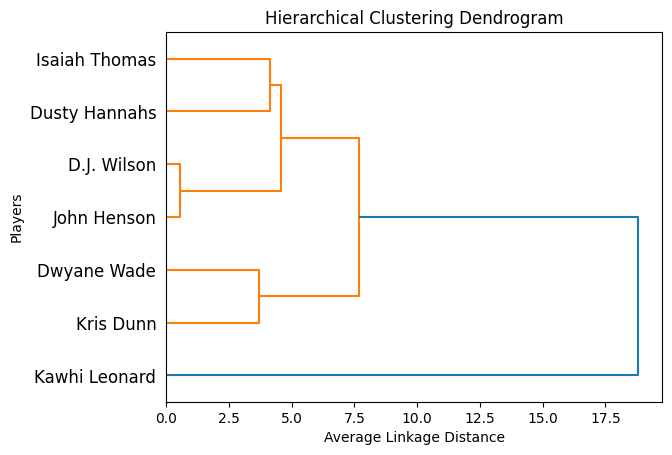

In [52]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Calculate the linkage matrix using Average Linkage
linkage_matrix = linkage(selected_players[['PTS', 'REB']], method='average')

# Create the dendrogram
dendrogram(linkage_matrix, labels=selected_players['PLAYER'].tolist(), orientation='right')

# Add labels and show the plot
plt.xlabel('Average Linkage Distance')
plt.ylabel('Players')
plt.title('Hierarchical Clustering Dendrogram')
plt.show()

# KMeans Clustering


The k-means clustering algorithm can be summarized in three main steps:

- Step 1: Initialization - Randomly initialize k centroids

- Step 2: Assignment - Assign each point to the nearest centroid
- Step 3: Update Centroids - Recalculate centroids

Repeat Steps 2 and 3 until the centroids no longer change significantly, at which point the algorithm has converged, and the final clusters have been found.

![](https://github.com/aaubs/ds-master/raw/main/data/Images/kmeans_clustering.bin)

In [53]:
from sklearn.datasets import make_blobs

# Generate synthetic data for demonstration
X, y = make_blobs(n_samples=300, centers=4, random_state=42, cluster_std=1.0)

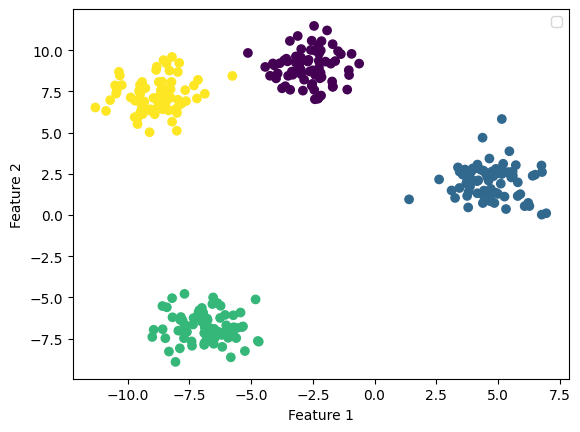

In [54]:
# Visualize the clusters
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
# plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroids')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
# plt.title(f'K-Means Clustering (K={k})')
plt.legend()
plt.show()

In [55]:
# Step 1: Initialization - Randomly initialize k centroids
k = 4
random_indices = np.random.choice(len(X), k, replace=False)
centroids = X[random_indices]

In [56]:
centroids

array([[-7.15118612,  8.20516267],
       [ 5.15492652,  5.82590117],
       [-8.44387561,  6.90253843],
       [-8.6564615 ,  7.5717435 ]])

In [57]:
# Step 2: Assignment - Assign each point to the nearest centroid
distances = np.sqrt(((X - centroids[:, np.newaxis])**2).sum(axis=2))
labels = np.argmin(distances, axis=0)

In [59]:
distances

array([[ 2.75780899,  2.8448703 ,  5.4800218 , ...,  3.19308249,
         1.84833451,  0.94500733],
       [14.46712484, 14.89531332,  7.11887809, ...,  9.86610153,
        14.33076025, 13.43023591],
       [ 0.95546717,  1.25539417,  6.81570036, ...,  4.89877359,
         2.13086357,  1.83906445],
       [ 1.27158126,  1.21932458,  6.97333385, ...,  4.8225835 ,
         1.43753895,  1.30359459]])

In [60]:
distances.shape

(4, 300)

In [62]:
distances[0][0]

2.75780898742529

In [63]:
distances[1][0]

14.46712483622223

In [64]:
distances[2][0]

0.9554671708846879

In [65]:
distances[3][0]

1.2715812639679256

In [66]:
labels[0]

2

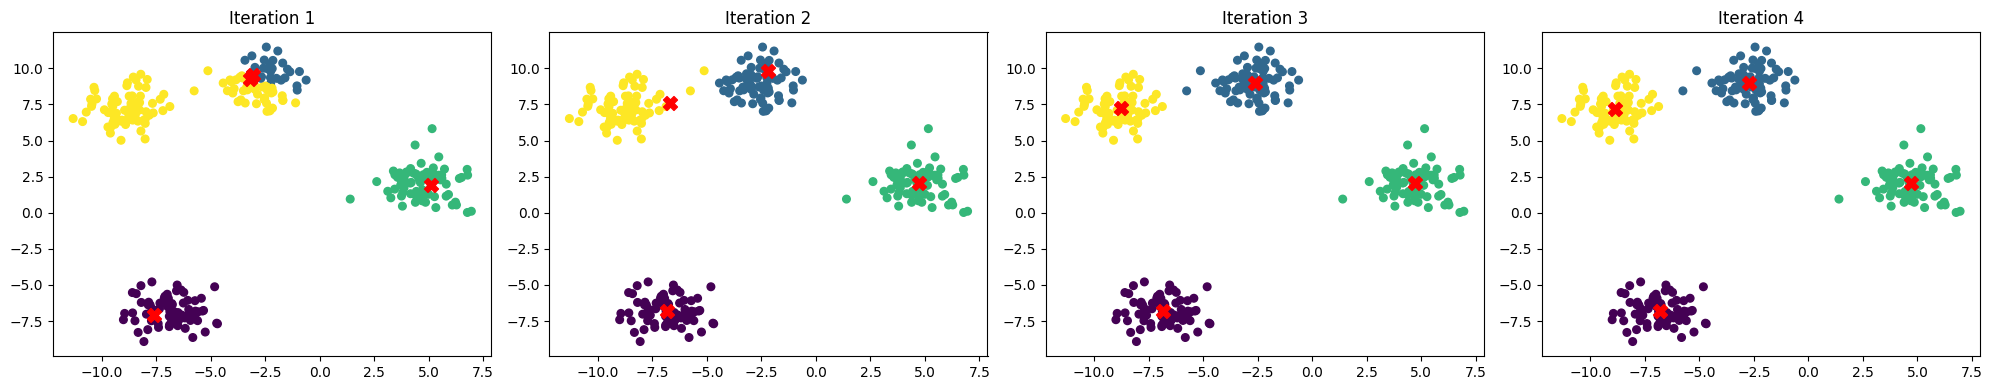

In [32]:
# @title KMeans Clustering Process Test 1
# Modified k-means function to capture the output at each iteration for visualization
import matplotlib.pyplot as plt
def kmeans_with_visualization(X, k, max_iters=10):
    # Step 1: Initialization - Randomly initialize k centroids
    random_indices = np.random.choice(len(X), k, replace=False)
    centroids = X[random_indices]

    iteration_visualizations = []

    for i in range(max_iters):
        # Step 2: Assignment - Assign each point to the nearest centroid
        distances = np.sqrt(((X - centroids[:, np.newaxis])**2).sum(axis=2))
        labels = np.argmin(distances, axis=0)

        # Capture current state for visualization
        iteration_visualizations.append((centroids.copy(), labels.copy()))

        # Step 3: Update Centroids - Recalculate centroids
        new_centroids = np.array([X[labels == j].mean(axis=0) for j in range(k)])

        # Check for convergence
        if np.all(centroids == new_centroids):
            break

        centroids = new_centroids

    return iteration_visualizations

# Run k-means algorithm and capture the output at each iteration
iteration_visualizations = kmeans_with_visualization(X, k=4)

# Plot the clusters and centroids at each iteration
fig, axes = plt.subplots(1, len(iteration_visualizations), figsize=(20, 4))
for i, (centroids, labels) in enumerate(iteration_visualizations):
    axes[i].scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=30)
    axes[i].scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=100)
    axes[i].set_title(f"Iteration {i + 1}")

plt.tight_layout()
plt.show()

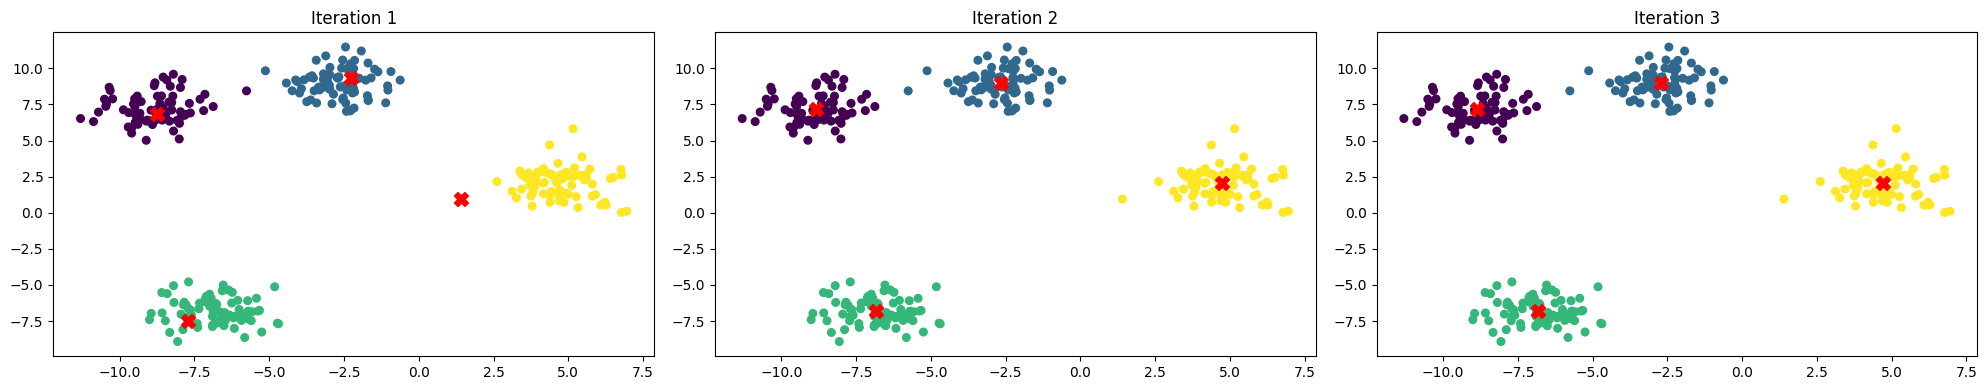

In [33]:
# @title KMeans Clustering Process
# Modified k-means function to capture the output at each iteration for visualization
import matplotlib.pyplot as plt
def kmeans_with_visualization(X, k, max_iters=10):
    # Step 1: Initialization - Randomly initialize k centroids
    random_indices = np.random.choice(len(X), k, replace=False)
    centroids = X[random_indices]

    iteration_visualizations = []

    for i in range(max_iters):
        # Step 2: Assignment - Assign each point to the nearest centroid
        distances = np.sqrt(((X - centroids[:, np.newaxis])**2).sum(axis=2))
        labels = np.argmin(distances, axis=0)

        # Capture current state for visualization
        iteration_visualizations.append((centroids.copy(), labels.copy()))

        # Step 3: Update Centroids - Recalculate centroids
        new_centroids = np.array([X[labels == j].mean(axis=0) for j in range(k)])

        # Check for convergence
        if np.all(centroids == new_centroids):
            break

        centroids = new_centroids

    return iteration_visualizations

# Run k-means algorithm and capture the output at each iteration
iteration_visualizations = kmeans_with_visualization(X, k=4)

# Plot the clusters and centroids at each iteration
fig, axes = plt.subplots(1, len(iteration_visualizations), figsize=(20, 4))
for i, (centroids, labels) in enumerate(iteration_visualizations):
    axes[i].scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=30)
    axes[i].scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=100)
    axes[i].set_title(f"Iteration {i + 1}")

plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


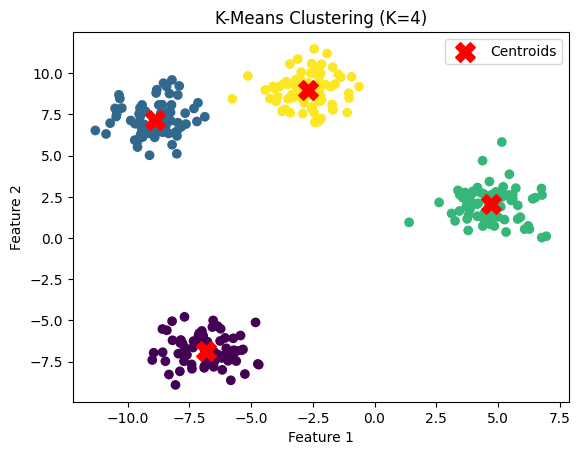

In [67]:
from sklearn.cluster import KMeans

# Fit the K-Means model
kmeans = KMeans(n_clusters=k)
kmeans.fit(X)

# Get cluster labels and centroids
cluster_labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Visualize the clusters
plt.scatter(X[:, 0], X[:, 1], c=cluster_labels, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroids')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title(f'K-Means Clustering (K={k})')
plt.legend()
plt.show()

###**How to find the optimal number of clusters for k-means?**

To determine the optimal number of clusters for a k-means clustering algorithm, you can use various methods and techniques, such as the elbow method, silhouette score, or the gap statistic. These methods help you assess the quality of clustering for different numbers of clusters and select the one that provides the best balance between cluster compactness and separation.

Elbow Method involves running k-means clustering with a range of different cluster numbers (k values) and plotting the within-cluster sum of squares (WCSS) or distortion for each k. The point where the WCSS starts to level off and form an "elbow" in the plot is often considered the optimal number of clusters.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

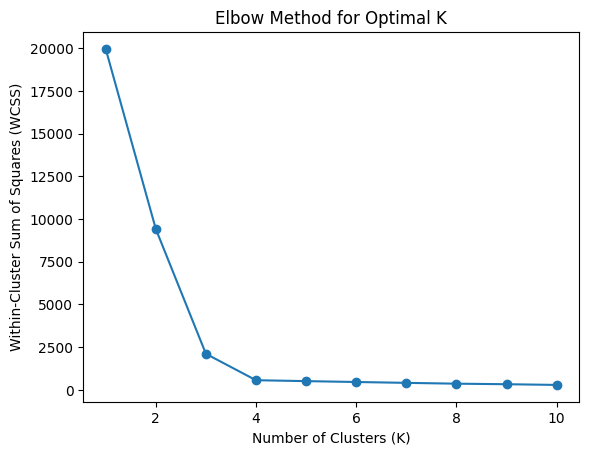

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


# Initialize an empty list to store the within-cluster sum of squares (WCSS)
wcss = []

# Define a range of K values to test
k_values = range(1, 11)  # You can adjust the range as needed

# Calculate WCSS for each K value
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plot the WCSS values
plt.plot(k_values, wcss, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal K')
plt.show()

##**Exercise 2: Perfrom Kmeans clustering for nba dataset?**

In [36]:
from sklearn.preprocessing import StandardScaler


nba_data_filtered = nba.drop(columns=['Unnamed: 0', 'PLAYER', 'TEAM'])

# Standardize the data
scaler = StandardScaler()
nba_data_scaled = scaler.fit_transform(nba_data_filtered)

# Show the first few rows of the scaled data
pd.DataFrame(nba_data_scaled, columns=nba_data_filtered.columns).head()


,AGE,GP,W,L,MIN,PTS,FGM,FGA,FG%,3PM,...,REB,AST,TOV,STL,BLK,PF,FP,DD2,TD3,+/-
0,0.628930,1.104851,1.658169,0.166161,1.914619,4.502553,3.446527,3.805632,0.018697,4.876506,...,1.179173,3.146504,4.965789,3.349635,0.762053,1.690343,3.666049,2.948395,3.816974,1.529112
1,0.628930,1.066425,1.343244,0.440082,1.925595,3.175691,2.721698,3.043083,-0.017109,3.633577,...,1.810846,1.228760,2.062529,3.834294,0.021427,1.320806,2.823851,1.950662,0.429316,2.093281
2,-0.558153,0.874296,1.973094,-0.587121,1.475591,3.126548,3.084113,2.236960,1.236092,-0.219506,...,3.508468,2.244036,3.324816,1.653328,2.737057,1.813523,3.442060,4.943861,2.687755,2.939535
3,-0.320736,0.566889,1.154289,-0.244720,1.574372,3.093786,2.676397,2.541980,0.394657,0.401959,...,3.942743,1.003144,3.072359,0.199350,3.724559,1.936702,3.218071,5.342954,0.993926,1.905225
4,1.816013,0.221057,0.209514,0.166161,1.739008,3.077405,3.129415,2.803425,0.627394,1.396303,...,1.929285,3.597737,3.198587,1.653328,0.515178,-0.034165,3.065759,2.748848,4.381583,0.745543


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

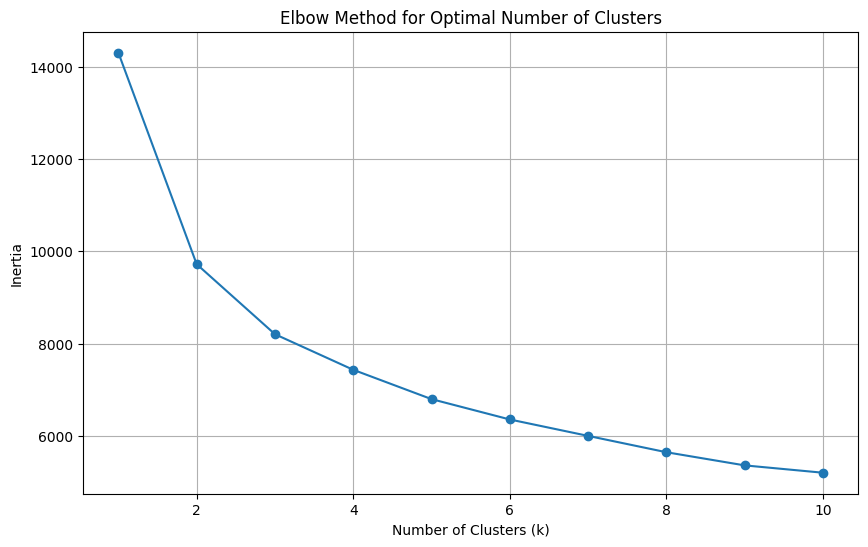

In [37]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Initialize variables
inertia_values = []
k_range = range(1, 11)  # We will check for up to 10 clusters

# Run K-means with different k values and store the inertia (sum of squared distances)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(nba_data_scaled)
    inertia_values.append(kmeans.inertia_)

# Plot the Elbow method graph
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia_values, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

In [38]:
# Run K-means with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(nba_data_scaled)

# Add the cluster labels to the original data for interpretation
nba['Cluster'] = kmeans_labels

# Show the first few rows of the data with cluster labels
nba.head()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Unnamed: 0,PLAYER,TEAM,AGE,GP,W,L,MIN,PTS,FGM,...,AST,TOV,STL,BLK,PF,FP,DD2,TD3,+/-,Cluster
0,1,James Harden,HOU,29,78,51,27,36.8,36.1,10.8,...,7.5,5.0,2.0,0.7,3.1,58.7,34,7,4.6,1
1,2,Paul George,OKC,29,77,46,31,36.9,28.0,9.2,...,4.1,2.7,2.2,0.4,2.8,49.3,24,1,6.4,1
2,3,Giannis Antetokounmpo,MIL,24,72,56,16,32.8,27.7,10.0,...,5.9,3.7,1.3,1.5,3.2,56.2,54,5,9.1,1
3,4,Joel Embiid,PHI,25,64,43,21,33.7,27.5,9.1,...,3.7,3.5,0.7,1.9,3.3,53.7,58,2,5.8,1
4,5,LeBron James,LAL,34,55,28,27,35.2,27.4,10.1,...,8.3,3.6,1.3,0.6,1.7,52.0,32,8,2.1,1
